## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from shutil import move
from datetime import datetime

In [3]:
PATH = 'data/seedlings/'
OUTPUT = 'output/submissions/kg-seedlings/'

In [4]:
os.makedirs('data/seedlings/models', exist_ok=True)
os.makedirs('cache/seedlings/tmp', exist_ok=True)
os.makedirs('data/seedlings/sample', exist_ok=True)
os.makedirs('data/seedlings/sample/train', exist_ok=True)
os.makedirs('data/seedlings/sample/valid', exist_ok=True)

!ln -s ~/datasets/kaggle/seedlings/train {PATH}
!ln -s ~/datasets/kaggle/seedlings/test {PATH}
!ln -s ~/cache/seedlings/tmp {PATH}

ln: failed to create symbolic link 'data/seedlings/train': File exists
ln: failed to create symbolic link 'data/seedlings/test': File exists
ln: failed to create symbolic link 'data/seedlings/tmp': File exists


In [5]:
ls {PATH}

labels.csv  labels_orig.csv  models/  sample/  test@  tmp/  train@


In [6]:
ls {PATH}train

data/seedlings/train@


In [7]:
ls {PATH}test

data/seedlings/test@


## Moved the data into one folder for train and one for test
Make CSV file for labels

In [8]:
from fastai.plots import *
from seedlings import *

In [9]:
files = os.listdir(f'{PATH}train')

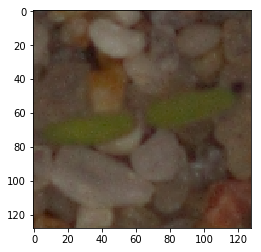

In [10]:
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(128, 128, 3)

In [12]:
## Make CSV with labels

In [13]:
#df = pd.DataFrame(columns=['file','species'])
#for image in glob(f'{PATH}train/**/*.png'):
#    dir_ = image.split('/')
#    file_, species = dir_[-1], dir_[-2]
#
#    df = df.append({
#        "file": file_,
#        "species": species
#        }, ignore_index=True)
#
#df.to_csv(f'{PATH}labels.csv', index=False)    

# Note to self: I removed a few very blurry images or images that were missing plants by hand.

In [25]:
# What sizes are our training files
from PIL import Image

def get_img_df(folder):
    files = os.listdir(folder)
    images = []
    im_height = []
    im_width = []

    for img in files:
        im = Image.open(f'{folder}/{img}')
        images.append(img)
        im_height.append(im.height)
        im_width.append(im.width)
    

    return pd.DataFrame({"height": im_height, 
                         "width": im_width}, index=images)

df_train = get_img_df(f'{PATH}train/')
df_train.describe()

,height,width
count,4750.000000,4750.000000
mean,370.730105,371.465895
std,318.649607,323.275012
min,49.000000,49.000000
25%,140.000000,140.000000
50%,266.500000,266.500000
75%,507.000000,507.750000
max,3457.000000,3991.000000


In [26]:
df_test = get_img_df(f'{PATH}test/')
df_test.describe()

,height,width
count,794.000000,794.000000
mean,269.492443,269.492443
std,43.109211,43.109211
min,200.000000,200.000000
25%,232.000000,232.000000
50%,267.000000,267.000000
75%,307.000000,307.000000
max,349.000000,349.000000


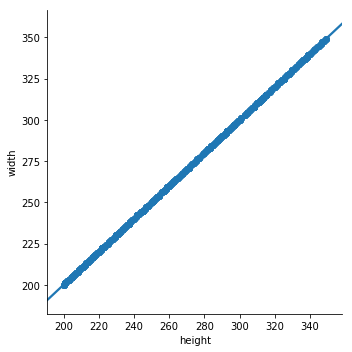

In [27]:
import seaborn as sns
sns.lmplot(x='height', y='width', data=df_test)

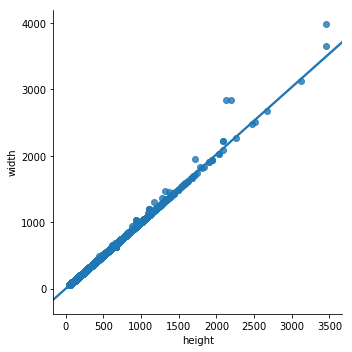

In [28]:
sns.lmplot(x='height', y='width', data=df_train)

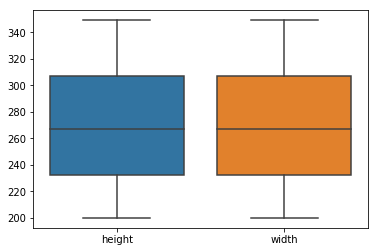

In [29]:
sns.boxplot(data=df_test)

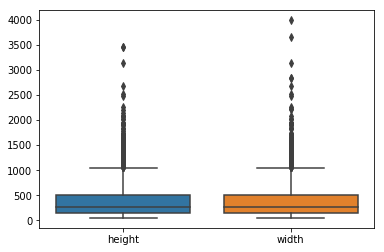

In [30]:
sns.boxplot(data=df_train)

# Setup

In [31]:
import time

t = int( time.time() * 1000.0 )
sd =  ((t & 0xff000000) >> 24) + ((t & 0x00ff0000) >>  8) + ((t & 0x0000ff00) <<  8) + ((t & 0x000000ff) << 24)  

In [32]:
labels_csv = f'{PATH}labels.csv'
n = len(list(open(labels_csv)))-1

# NB NB NB the classes are quite imbalance and I am sure that this might not
# work as well as it could
val_idxs = get_cv_idxs(n, val_pct=0.1, seed=sd)

In [33]:
ls -1 {PATH}test/ | wc -l

794


In [34]:
ls {PATH}train/ -1 | wc -l

4750


In [51]:
arch = resnet50
sz=300
bs=32
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [52]:
data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test', val_idxs=val_idxs, tfms=tfms, bs=bs, num_workers=4)
learn2 = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


In [53]:
len(data.classes), data.classes

(12,
 ['Black-grass',
  'Charlock',
  'Cleavers',
  'Common_Chickweed',
  'Common_wheat',
  'Fat_Hen',
  'Loose_Silky-bent',
  'Maize',
  'Scentless_Mayweed',
  'Shepherds_Purse',
  'Small-flowered_Cranesbill',
  'Sugar_beet'])

## Training - train over all data
The dataset is relativley small and this approach picks k random validations sets and trains over them.

A possible improvement would be to ensure that the validation sets are always balanced with regards to the number of examples in each class.

In [54]:
learn2.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 63%|██████▎   | 75/119 [00:00<00:00, 124.64it/s, loss=8.04]


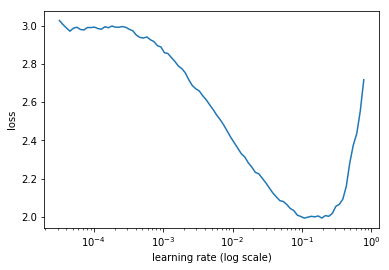

In [55]:
learn2.sched.plot()

In [56]:
folds = 5
val_pct = 0.2
lr = 0.02

# train at mean size of images in test set
sizes = [300]

for fold in range(1, folds+1):
    print("======= FOLD %d ========" % fold)
    # After some experiments, found out that training on just large images
    # was sufficient.
    for sz in sizes:
        print("====== SIZE %d =========" % sz)
        val_idxs = get_cv_idxs(n, val_pct=val_pct, seed=sd)
        tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
        data = ImageClassifierData.from_csv(PATH, 'train', 
                                            labels_csv, 
                                            test_name='test', 
                                            val_idxs=val_idxs,
                                            tfms=tfms,
                                            bs=bs)
        
        # speeds up by downsizing the largest images in dataset to 
        # smaller size (slow, cached :D)
        data = data.resize(max(sizes), 'tmp')
        learn2.set_data(data)
    
        learn2.freeze()
        learn2.fit(lr, 8)
              
        # differential train all layers
        learn2.unfreeze()
        lrs=np.array([lr/18,lr/12,lr/3])
        learn2.fit(lrs, 3, cycle_len=2, cycle_mult=2)

======= FOLD 1 ========
====== SIZE 300 =========


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.008973   0.602256   0.791022  
    1      0.727742   0.510922   0.813393                     
    2      0.566217   0.462366   0.843105                     
    3      0.488542   0.432181   0.85878                      
    4      0.398569   0.39941    0.87128                      
    5      0.333423   0.407784   0.863988                    
    6      0.28509    0.406455   0.869742                     
    7      0.267434   0.39127    0.866617                    



HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.518327   0.343909   0.886359  
    1      0.491074   0.324562   0.883234                    
    2      0.47431    0.325017   0.884821                    
    3      0.448391   0.312346   0.897321                    
    4      0.384487   0.302627   0.896776                    
    5      0.375376   0.292836   0.908284                    
    6      0.398841   0.316613   0.898363                    
    7      0.401072   0.310184   0.899901                    
    8      0.362393   0.286358   0.91245                     
    9      0.34751    0.280173   0.906696                    
    10     0.344434   0.270143   0.90253                     
    11     0.336023   0.275945   0.90878                     
    12     0.34361    0.28129    0.90878                     
    13     0.32426    0.270691   0.903571                    

======= FOLD 2 ========
====== SIZE 300 =========


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.477767   0.317325   0.900446  
    1      0.46111    0.373272   0.870734                    
    2      0.422429   0.285833   0.904067                    
    3      0.394505   0.273101   0.909325                    
    4      0.370753   0.297488   0.9062                      
    5      0.416621   0.307496   0.896329                    
    6      0.384801   0.316104   0.896825                    
    7      0.3457     0.320983   0.897272                    



HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.499433   0.224852   0.919742  
    1      0.261841   0.167274   0.948958                    
    2      0.241466   0.159673   0.946875                    
    3      0.166241   0.14441    0.957292                    
    4      0.122787   0.117281   0.963542                    
    5      0.110839   0.112879   0.967708                    
    6      0.145865   0.148962   0.956746                    
    7      0.099084   0.145381   0.95625                      
    8      0.088295   0.119676   0.96875                      
    9      0.068959   0.103111   0.969792                     
    10     0.060009   0.102808   0.971875                     
    11     0.05908    0.103217   0.969792                     
    12     0.054687   0.102872   0.967708                     
    13     0.051372   0.103739   0.96875                      

======= FOLD 3 ========
====== SIZE 300 =========


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.038897   0.099933   0.969792  
    1      0.036214   0.122272   0.959375                     
    2      0.030892   0.100124   0.973958                     
    3      0.037028   0.105662   0.970833                     
    4      0.034685   0.102223   0.975                        
    5      0.045414   0.103661   0.971875                     
    6      0.042122   0.115248   0.964583                     
    7      0.039      0.105251   0.970833                     



HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.085875   0.130278   0.965625  
    1      0.057166   0.105093   0.975                        
    2      0.067867   0.141809   0.963542                     
    3      0.058756   0.099332   0.969792                     
    4      0.033805   0.105419   0.972917                     
    5      0.034442   0.103273   0.976042                     
    6      0.04593    0.147985   0.95625                      
    7      0.05055    0.156814   0.960913                     
    8      0.042137   0.103246   0.977083                     
    9      0.038625   0.130209   0.966667                     
    10     0.034264   0.108518   0.975                        
    11     0.026075   0.110172   0.977083                     
    12     0.021417   0.109783   0.976042                     
    13     0.021729   0.108697   0.971875                     

======= FOLD 4 ========
====== SIZE 300 =========


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.009772   0.113214   0.971875  
    1      0.013562   0.117155   0.972917                     
    2      0.013233   0.123605   0.969792                     
    3      0.015238   0.130931   0.969792                     
    4      0.014199   0.123385   0.973958                     
    5      0.020182   0.127966   0.973958                     
    6      0.016406   0.124694   0.972917                     
    7      0.016249   0.133299   0.969792                     



HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.030787   0.145482   0.96875   
    1      0.025359   0.131392   0.969792                     
    2      0.039615   0.240921   0.952083                     
    3      0.053716   0.136778   0.96875                      
    4      0.027025   0.124138   0.969792                     
    5      0.01718    0.12335    0.967708                     
    6      0.041101   0.126852   0.96875                      
    7      0.062392   0.140044   0.967163                     
    8      0.039891   0.132057   0.970833                     
    9      0.029459   0.140378   0.966667                     
    10     0.023749   0.117508   0.969792                     
    11     0.021202   0.113267   0.975                        
    12     0.013573   0.109297   0.973958                     
    13     0.010083   0.113468   0.975                        

======= FOLD 5 ========
====== SIZE 300 =========


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.005419   0.11155    0.975     
    1      0.007875   0.116284   0.973958                      
    2      0.0068     0.115544   0.973958                      
    3      0.008273   0.114371   0.972917                      
    4      0.007677   0.120211   0.973958                      
    5      0.007444   0.118877   0.973958                      
    6      0.00693    0.119602   0.972917                      
    7      0.006906   0.119137   0.972917                      



HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.034712   0.123443   0.969792  
    1      0.017434   0.131075   0.966667                     
    2      0.028481   0.123256   0.970833                     
    3      0.027411   0.140782   0.973958                     
    4      0.013559   0.128358   0.973958                     
    5      0.010403   0.12219    0.975                        
    6      0.021316   0.144506   0.969792                     
    7      0.020233   0.135952   0.96875                      
    8      0.016996   0.151319   0.965625                     
    9      0.018978   0.12143    0.972917                     
    10     0.01019    0.14168    0.971875                     
    11     0.010622   0.127822   0.972917                     
    12     0.005428   0.1239     0.975                         
    13     0.007342   0.121864   0.976042                      



In [57]:
import random
idd = random.randint(1,10000)
learn2.save(f'{idd}_all_data')
print(idd)

4997


In [58]:
learn2.load(f'{idd}_all_data')

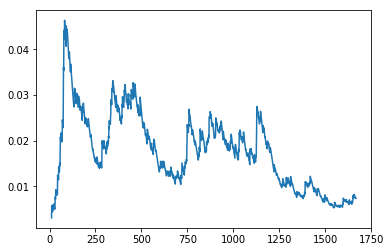

In [59]:
learn2.sched.plot_loss()

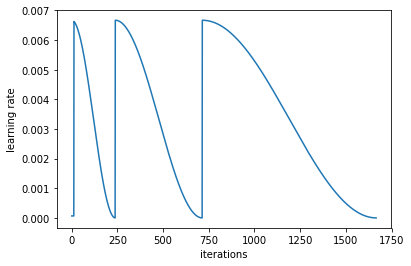

In [60]:
learn2.sched.plot_lr()

## Evaluate learner



In [61]:
log_preds, y = learn2.TTA()

In [62]:
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, axis=1)

In [63]:
accuracy_np(probs, y)

0.9768177028451

In [64]:
cm2 = confusion_matrix(y, preds)

[[ 50   0   0   0   0   1   8   0   0   0   0   0]
 [  0  84   0   0   0   0   0   0   0   0   0   0]
 [  0   0  49   1   0   0   0   0   0   0   0   0]
 [  0   0   1 133   0   0   0   0   0   0   0   0]
 [  1   0   0   0  44   0   0   0   0   0   0   0]
 [  0   0   0   0   0  83   0   0   0   0   0   0]
 [  3   0   0   0   0   0 117   0   0   0   0   0]
 [  0   0   0   0   0   0   0  33   0   0   0   0]
 [  0   0   0   2   0   0   0   0 119   1   0   0]
 [  0   0   0   0   0   0   0   0   1  43   0   0]
 [  1   0   0   0   0   0   0   0   0   0  98   0]
 [  0   0   0   1   1   0   0   0   0   0   0  74]]


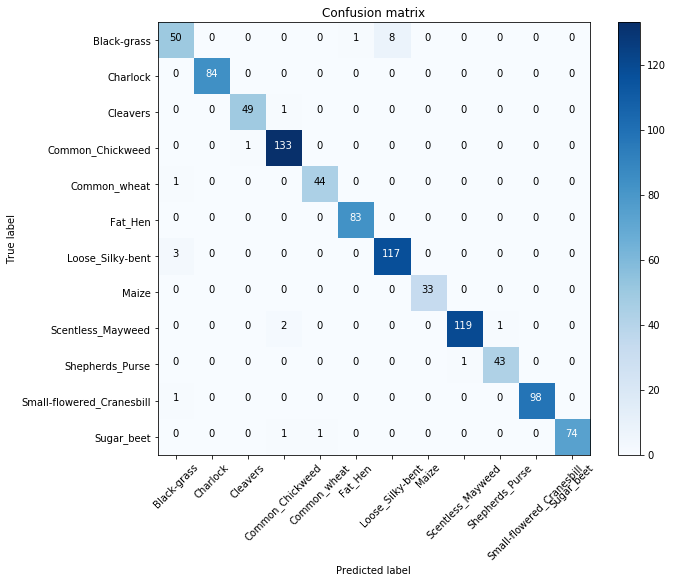

In [68]:
plot_confusion_matrix(cm2, data.classes, figsize=(10,8))

In [66]:
sklearn.metrics.f1_score(y, preds, average='micro') 

0.9768177028451

## Test data

In [81]:
t_log_preds = learn2.predict(is_test=True)
t_log_preds.shape

(794, 12)

In [82]:
t_log_preds = np.argmax(t_log_preds, axis=1)
preds_classes = [data.classes[i].replace("_", " ") for i in t_log_preds]

In [83]:
t_probs = np.exp(t_log_preds)

In [57]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(f'{OUTPUT}/submission_8c.csv', index=False)

## Troubleshooting

In [58]:
for cls_id, cls_name in enumerate(data.classes):
    print(cls_id, " : ", cls_name)

0  :  Black-grass
1  :  Charlock
2  :  Cleavers
3  :  Common_Chickweed
4  :  Common_wheat
5  :  Fat_Hen
6  :  Loose_Silky-bent
7  :  Maize
8  :  Scentless_Mayweed
9  :  Shepherds_Purse
10  :  Small-flowered_Cranesbill
11  :  Sugar_beet


In [59]:
unique, counts = np.unique(data.val_y, return_counts=True)
dict(zip(unique, counts))

{0: 29,
 1: 45,
 2: 20,
 3: 68,
 4: 10,
 5: 53,
 6: 72,
 7: 20,
 8: 54,
 9: 19,
 10: 46,
 11: 38}

In [60]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

In [61]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    
    title_probs = []
    for x in idxs:
        max_value = probs[x].max()
        max_index = np.where(probs[x] == max_value)[0][0]
        tit = '%.2f : %s' % (max_value, data.classes[max_index])
        tit = tit + ('\n%s' % data.val_ds.fnames[x])
        title_probs.append(tit)

    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8))

In [62]:
def rand_by_mask(mask, n): return np.random.choice(np.where(mask)[0], n, replace=False)
def rand_by_correct(is_correct, n): return rand_by_mask((preds == y)==is_correct, n)

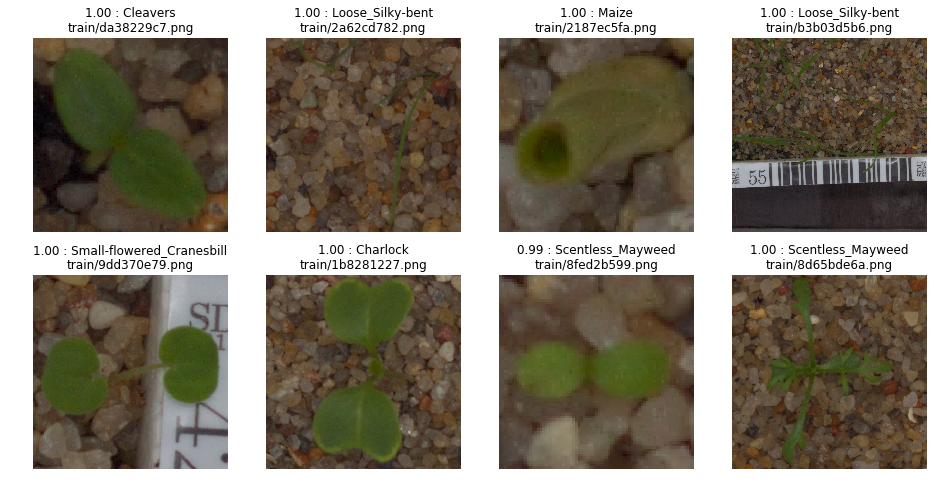

In [63]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True,8), "Correctly classified")

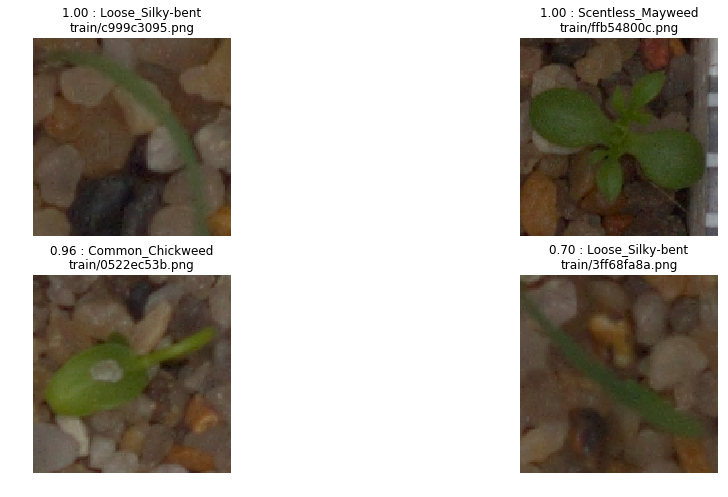

In [64]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False, 4), "Incorrectly classified")

In [67]:
# return random images that were actually in class X but predicted in class Y
def misclassified(actual, predicted, n):
    mask_y = (y==actual)
    mask_p = (preds==predicted)
    return rand_by_mask(mask_y & mask_p, n)

# return random images that were actually in class X but predicted in class Y
def correct(idx, n):
    mask_y = (y==idx)
    mask_p = (preds==idx)
    return rand_by_mask(mask_y & mask_p, n)

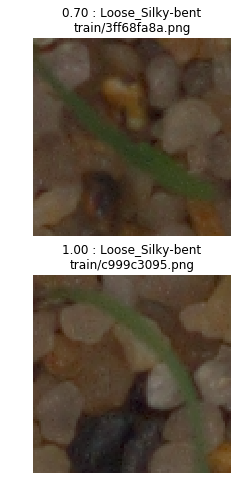

In [68]:
# plot misclassified class 0 as 6
plot_val_with_title(misclassified(0,6, 2), "True Class 0 incorrectly classified as class 6")

In [70]:
# plot misclassified class 6 as 0
plot_val_with_title(misclassified(6,0,1), "True Class 6 incorrectly classified as class 0")

ValueError: a must be non-empty

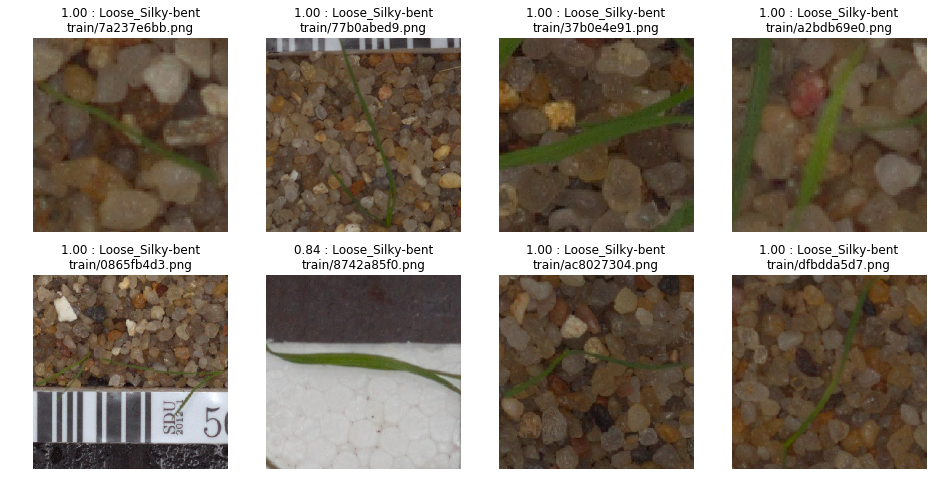

In [71]:
# plot correct class 6
plot_val_with_title(correct(6,8), "Correct class 6")

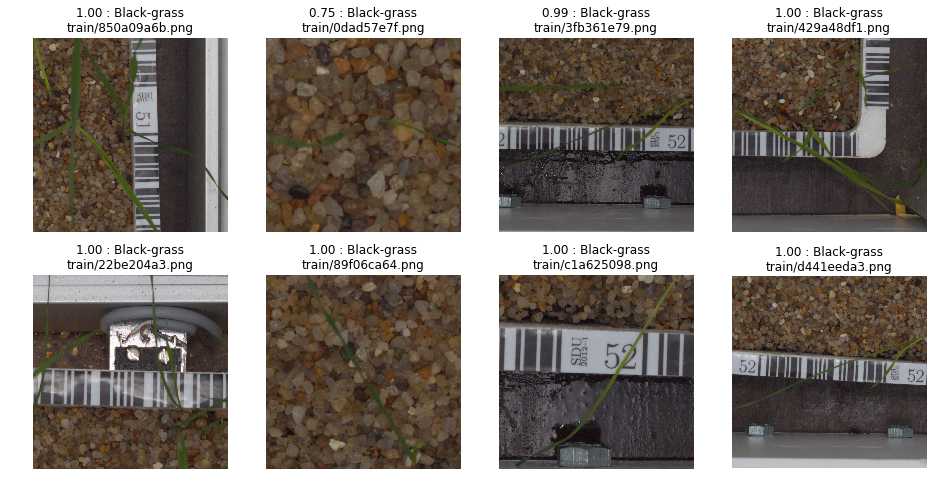

In [72]:
# plot correct class 0
plot_val_with_title(correct(0,8), "Correct class 0")